# Machine Learning Dynamical Systems

In [ ]:
### Install dependencies
!pip3.9 install numpy matplotlib scipy
!pip3.9 install tqdm plotly
!pip3.9 install torch torchvision torchaudio
!pip3.9 install optuna

In [1]:
#!/usr/bin/env python3
%matplotlib inline

# Basic import
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint


# Pytorch import
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from torchvision import transforms, datasets
import torch.nn.functional as F

# Import models
from models import LSTM, VarFFAE, FFNet, ESN

# Import training and evaluating functions
from training import train
from pi_training import pi_train

# Import functions for physical informed training
from pi_functions import L63_field, PILoss

# Import progress bars
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from time import sleep

# Optuna
import optuna
import plotly
from optuna.visualization import plot_parallel_coordinate, plot_param_importances, plot_contour


#Import sys
import sys

In [ ]:
### Test nets
encoded_space_dim = 2
layers_sizes = [3, 16,24]
drop_p = 0.3
params = {
    "encoded_space_dim" : encoded_space_dim,
    "layers_sizes" : layers_sizes,
    "act" : nn.ReLU(True),
    "drop_p" : drop_p
}


net_test = VarFFAE(params)

seed_input = torch.tensor((1,1,1), dtype=torch.float).unsqueeze(0).unsqueeze(0)

out = net_test(seed_input)
print(out)



## Dataset generation

(1000, 3)
(3000, 3)


Text(0.5, 0.92, 'Validation dataset')

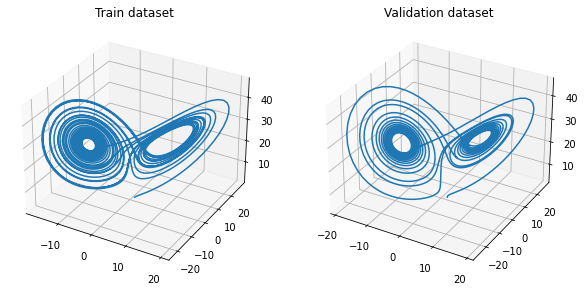

In [2]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

# Train dataset (discard first 100 steps)
state0 = [1.0, 1.0, 1.0]
train_steps = 4000
t_train = np.arange(0.0, train_steps*dt, dt)
train_dataset = odeint(f, state0, t_train)

test_dataset = train_dataset[3000:,:]
train_dataset = train_dataset[:3000,:]

print(test_dataset.shape)
print(train_dataset.shape)

# Validation dataset (different ic, discard first 100 steps)
state1 = [2.0, 0.0, 3.0]
val_steps = 2000
t_val = np.arange(0.0, val_steps*dt, dt)
val_dataset = odeint(f, state1, t_val)

fig = plt.figure(figsize = (10,20))
ax1 = fig.add_subplot(121, projection="3d")
ax1.plot(train_dataset[:, 0], train_dataset[:, 1], train_dataset[:, 2])
ax1.set_title("Train dataset")
ax2 = fig.add_subplot(122, projection="3d")
ax2.plot(val_dataset[:, 0], val_dataset[:, 1], val_dataset[:, 2])
ax2.set_title("Validation dataset")



In [ ]:
### Convert to tensor
l_seq = 100
train_sequences = int(3*train_steps/(4*l_seq))
val_sequences = int(val_steps/l_seq)

train_states = torch.tensor(train_dataset, requires_grad=True,dtype=torch.float)
train_states = torch.reshape(train_states, (train_sequences, l_seq, 3))
val_states = torch.tensor(val_dataset, requires_grad=False,dtype=torch.float)
val_states = torch.reshape(val_states, (val_sequences, l_seq, 3))

print(train_states.shape)
print(val_states.shape)
### Dataloader
torch.manual_seed(0)
train_dataloader = DataLoader(train_states, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_states, batch_size=16, shuffle=True)
print(next(iter(train_dataloader)).shape)

## Purely data driven approach

In [ ]:
### Hyperparameter optmization
#Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Define objective function
def objective(trial):
    
    # Define objects to be optimized
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-1, log = True)
    momentum = trial.suggest_float("momentum", 0.0, 1.0)
    drop_p = trial.suggest_float("dropout", 0.0, 1.0)
    hidden_units = trial.suggest_int("hidden_units", 1,40)
    layers_num = trial.suggest_int("layers_num", 1,5)
    
    # Define network
    input_size = 3
    model = LSTM(input_size, hidden_units, layers_num, drop_p)

   
    # Define the optimizer
    if optimizer_name == "Adam":
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    else:
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, momentum = momentum)
        
    # Define the loss function 
    loss_fn = nn.MSELoss()
    
    max_num_epochs = 100
    early_stopping = False
    train_loss, val_loss = train(model, device, train_dataloader, val_dataloader, loss_fn, optimizer, max_num_epochs, early_stopping)
    
    # Metric to be minimized is the last validation loss
    return np.mean(val_loss[-5:])


In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials= 20)
study.best_params  

In [ ]:
# Define network
input_size = 3
hidden_units = 100 #study.best_params["hidden_units"]
layers_num =  2 #study.best_params["layers_num"]
drop_p = 0.3 #study.best_params["dropout"]
torch.manual_seed(0)
net_dd = LSTM(input_size, hidden_units, layers_num, drop_p)

In [ ]:
### Training

"""
# Define the optimizer
if  study.best_params["optimizer"]=="Adam":
    optimizer = getattr(optim, study.best_params["optimizer"])(net_dd.parameters(), lr = study.best_params["learning_rate"])
else:
    optimizer = getattr(optim, study.best_params["optimizer"])(net_dd.parameters(), lr = study.best_params["learning_rate"], momentum = study.best_params["momentum"])
"""
# Optimizer
optimizer = optim.Adam(net_dd.parameters(), lr = 0.001, weight_decay = 0.0)
# Define the loss function
loss_fn = nn.MSELoss()

#Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Move network to the proper device
net_dd.to(device)

### Training
max_num_epochs = 2000
early_stopping = True
train_loss, val_loss = train(net_dd, device, train_dataloader, val_dataloader, loss_fn, optimizer, max_num_epochs, early_stopping)
  

In [ ]:
### Plot losses
plt.semilogy(train_loss, label="Train loss")
plt.semilogy(val_loss, label="Validation loss")
plt.legend()

In [ ]:
### Generate a trajectory with network

state = torch.tensor(test_dataset[0], dtype=torch.float).unsqueeze(0).unsqueeze(0)
h0 = torch.zeros(layers_num, 1, hidden_units)
c0 = torch.zeros(layers_num, 1, hidden_units)
rnn_state = (h0, c0)

net_states = []
for i in range(1000):
    with torch.no_grad():
        state = state.to(device)
        net_states.append(state[-1].squeeze().numpy())
        # Forward pass
        state, rnn_state = net_dd(state, rnn_state)
        
        
        
### Plotting
net_states = np.array(net_states)


fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_xlabel("t")
ax1.set_ylabel("x")
ax2.set_xlabel("t")
ax2.set_ylabel("y")
ax3.set_xlabel("t")
ax3.set_ylabel("z")

ax1.plot(t_train[3000:],net_states[:, 0], label="Predicted")
ax1.plot(t_train[3000:],test_dataset[:, 0], label="Actual")
ax1.legend()
ax2.plot(t_train[3000:],net_states[:, 1], label="Predicted")
ax2.plot(t_train[3000:],test_dataset[:, 1], label="Actual")
ax2.legend()
ax3.plot(t_train[3000:],net_states[:, 2], label="Predicted")
ax3.plot(t_train[3000:],test_dataset[:, 2], label="Actual")
ax3.legend()
plt.tight_layout()

## Physical informed dynamics

In [ ]:
### Hyperparameter optmization
#Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Define annealing
max_num_epochs = 1000
initial_value = 5
exp_decay = np.exp(-np.log(initial_value) / max_num_epochs * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
annealing = [initial_value * (exp_decay ** i) for i in range(max_num_epochs)]
    
# Define loss function
loss_fn = PILoss(dt,field = L63_field(rho = 28.0, sigma = 10.0, beta = 8.0/3.0), annealing= annealing)

# Define objective function
def objective(trial):
    
    # Define objects to be optimized
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-1, log = True)
    momentum = trial.suggest_float("momentum", 0.0, 1.0)
    hidden_units = trial.suggest_int("hidden_units", 1,40)
    layers_num = trial.suggest_int("layers_num", 1,3)
    drop_p = trial.suggest_float("dropout", 0.0, 1.0)
   
    # Define network
    input_size = 3
    model = LSTM(input_size, hidden_units, layers_num, drop_p)

   
    # Define the optimizer
    if optimizer_name == "Adam":
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    else:
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, momentum = momentum)
        
    # Train
    max_num_epochs = 1000
    early_stopping = False
    train_loss, val_loss = pi_train(model, device, train_dataloader, val_dataloader, loss_fn, optimizer, max_num_epochs, early_stopping)
    
    # Metric to be minimized is the last validation loss
    return np.mean(val_loss[-5:])


In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials= 20)
study.best_params  

In [ ]:
# Define network
input_size = 3
hidden_units = 100#study.best_params["hidden_units"]
layers_num =  2#study.best_params["layers_num"]
drop_p = 0.3#study.best_params["dropout"]
net_pi = LSTM(input_size, hidden_units, layers_num, drop_p)

In [ ]:
### Training 

"""
# Define the optimizer
if  study.best_params["optimizer"]=="Adam":
    optimizer = getattr(optim, study.best_params["optimizer"])(net_pi.parameters(), lr = study.best_params["learning_rate"])
else:
    optimizer = getattr(optim, study.best_params["optimizer"])(net_pi.parameters(), lr = study.best_params["learning_rate"], momentum = study.best_params["momentum"])
"""
optimizer = optim.Adam(net_pi.parameters())
# Iterate through the dataloader for "num_epochs"
max_num_epochs = 1000

### Define exploration profile
initial_value = 5
exp_decay = np.exp(-np.log(initial_value) / max_num_epochs * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
annealing = [initial_value * (exp_decay ** i) for i in range(max_num_epochs)]
plt.plot(annealing)
# Define loss functions
loss_fn = PILoss(dt,field = L63_field(rho = 28.0, sigma = 10.0, beta = 8.0/3.0), annealing = annealing)

In [ ]:
#Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Move network to the proper device
net_pi.to(device)

### Training
early_stopping = True
train_loss, val_loss = pi_train(net_pi, device, train_dataloader, val_dataloader, loss_fn, optimizer, max_num_epochs, early_stopping)


In [ ]:
### Plot losses
plt.semilogy(train_loss, label="Train loss")
plt.semilogy(val_loss, label="Validation loss")
plt.legend()

In [ ]:
### Find initial state of the RNN

# Prepare input
seed_input = torch.tensor(test_dataset[0], dtype=torch.float).unsqueeze(0).unsqueeze(0)
seed_input = seed_input.to(device)
net_pi.eval()

with torch.no_grad():
    # Forward pass
    net_out, initial_net_state = net_pi(seed_input)
    
print(net_out.shape)
print(initial_net_state[0].shape)

### Generate a trajectory with network

net_input = torch.tensor(test_dataset[0], dtype=torch.float).unsqueeze(0).unsqueeze(0)
net_state = initial_net_state

net_states = []
for i in range(1000):
    with torch.no_grad():
        net_input = net_input.to(device)
        net_states.append(net_input[-1].squeeze().numpy())
        # Forward pass
        net_input, net_state = net_pi(net_input, net_state)
        
        

### Plotting
net_states = np.array(net_states)

fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_xlabel("t")
ax1.set_ylabel("x")
ax2.set_xlabel("t")
ax2.set_ylabel("y")
ax3.set_xlabel("t")
ax3.set_ylabel("z")

ax1.plot(t_train[3000:],net_states[:, 0], label="Predicted")
ax1.plot(t_train[3000:],test_dataset[:, 0], label="Actual")
ax1.legend()
ax2.plot(t_train[3000:],net_states[:, 1], label="Predicted")
ax2.plot(t_train[3000:],test_dataset[:, 1], label="Actual")
ax2.legend()
ax3.plot(t_train[3000:],net_states[:, 2], label="Predicted")
ax3.plot(t_train[3000:],test_dataset[:, 2], label="Actual")
ax3.legend()
plt.tight_layout()

# Reservoir Networks

In [32]:
params = {
    "input_dimension" : 3,
    "hidden_dimension" : 500,
    "out_dimension" : 3,
    "beta" : 0.01,
    "a" : 2,
    "b" : 2,
}
net_esn = ESN(params)

In [33]:
print(net_esn.P)
net_esn.optimize(train_dataset)
print(net_esn.P)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ -2.65629947  -0.26693736  -2.48346789 ...  -1.9449775    2.60636561
    5.20435123]
 [ -2.65350554  -1.15337383  -3.24683295 ...  -1.62333227   2.56429902
    5.37316438]
 [ 24.48097699 -17.54148275  -9.80160065 ...  22.8258763  -24.2990211
   -0.75191844]]


In [34]:
pred = net_esn.forward(test_dataset)
pred = np.array(pred)
print(pred)

[[ 6.25508646e+00 -1.15491225e+00  3.26508723e+01]
 [-6.77244035e+02 -6.80646830e+02  7.04419671e+03]
 [-6.63402422e+02 -6.59885215e+02  7.64205257e+03]
 ...
 [-1.23076237e+03 -1.21610385e+03  8.48800112e+03]
 [-1.16968425e+03 -1.14970553e+03  8.48264447e+03]
 [-1.13518711e+03 -1.10868873e+03  8.51675256e+03]]


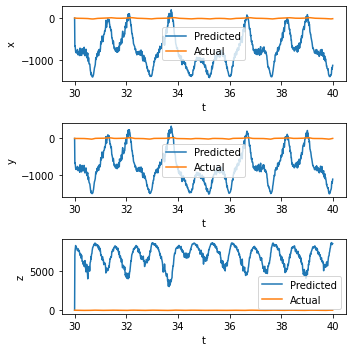

In [35]:

fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_xlabel("t")
ax1.set_ylabel("x")
ax2.set_xlabel("t")
ax2.set_ylabel("y")
ax3.set_xlabel("t")
ax3.set_ylabel("z")

ax1.plot(t_train[3000:],pred[:,0], label="Predicted")
ax1.plot(t_train[3000:],test_dataset[:, 0], label="Actual")
ax1.legend()
ax2.plot(t_train[3000:],pred[:, 1], label="Predicted")
ax2.plot(t_train[3000:],test_dataset[:, 1], label="Actual")
ax2.legend()
ax3.plot(t_train[3000:],pred[:, 2], label="Predicted")
ax3.plot(t_train[3000:],test_dataset[:, 2], label="Actual")
ax3.legend()
plt.tight_layout()

## Lyapunov exponents prediction

In [ ]:
### Classic computation

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01 # Dynamics timestep
n_time = 10 # How much larger than dt is tau
tau = n_time*dt # 


def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def J(state, t):
    """
    Compute the jacobian at a given state of the trajectory
    """
    x, y, z = state # Unpack the state vector
    jac = np.zeros((3,3)) # Initialize the jacobian
    # Compute derivatives
    jac[0][0] =  -sigma*x
    jac[0][1] = sigma
    jac[1][0] = rho - z
    jac[1][1] = -1.
    jac[1][2] = -x
    jac[2][0] = y
    jac[2][1] = x
    jac[2][2] = -beta
    
    return jac

# Define derivative function
def df(M, t, J):
    return np.dot(J,M)


# Train dataset (discard first 100 steps)
state0 = [1.0, 1.0, 1.0]
train_steps = 4000
t_train = np.arange(0.0, (100+train_steps)*dt, dt)
train_dataset = odeint(f, state0, t_train)[100:]

# Compute 
j = 10
M0 = np.eye(3)
time = np.arange((j-1)*tau, j*tau, dt)
Jac = J(train_dataset[(j-1)*n_time], (j-1)*tau) 
M = odeint(df, M0, time, args=(Jac,))[-1]
print(M)

In [ ]:
### Dataset generation

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01

eps = 0.01 # Perturbation
len_seq = 5 # Length of the pertubed sequence
t = np.arange(0.0, dt*len_seq, dt) # Time array

# Add pertubation dimension and dynamics dimension
print(states_dataset.shape) 
pd = np.expand_dims(states_dataset, axis=1)
pd = np.expand_dims(pd, axis=1)
perturbed_dataset = np.concatenate((pd, pd), axis=2)
perturbed_dataset = np.concatenate((perturbed_dataset, pd), axis=2)
print(perturbed_dataset.shape)


# Add perturbation
for i in range(3):
    perturbed_dataset[:,:,i,i] += eps
    
print(perturbed_dataset[0,:,0,:])

le_dataset = []
# Run the dynamics for all perturbations for len_seq steps
for state in perturbed_dataset:
    ev_dyn0 = np.expand_dims(odeint(f, state[0,0,:], t), axis=1)
    ev_dyn1 = np.expand_dims(odeint(f, state[0,1,:], t), axis=1)
    ev_dyn2 = np.expand_dims(odeint(f, state[0,2,:], t), axis=1)
   
    ev_dyn = np.concatenate((ev_dyn0, ev_dyn1), axis=1)
    ev_dyn = np.concatenate((ev_dyn, ev_dyn2), axis=1)
    le_dataset.append(ev_dyn)

# Convert to numpy
le_dataset = np.array(le_dataset)

In [ ]:
### Convert to tensor
l_seq = 20
num_sequences = int(4000/l_seq)

le_dataset = torch.tensor(le_dataset, requires_grad=True,dtype=torch.float)


### Dataloader
le_dataloader = DataLoader(le_dataset, batch_size=16, shuffle=True)
print(next(iter(le_dataloader)).shape)

### Trainig

In [ ]:
# Define network
input_size = 3
hidden_units = 10
layers_num = 2
drop_p = 0.3
net_le = LSTM(input_size, hidden_units, layers_num, drop_p)

In [ ]:
#Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Move network to the proper device
net_pi.to(device)
# Network in training mode (enable stochastic layers, e.g. dropout)
net_pi.train()



# Create pbar 
pbar = tqdm(range(num_epochs))

for epoch_num in pbar:
    epoch_losses = []
    
    i = 0
    for batch_sample in le_dataloader:
        
        ### Move samples to the proper device
        batch_sample = batch_sample.to(device)

        ### Prepare network input and labels
        net_input  = batch_sample[:, :-1, :]
        labels = batch_sample[:, 1:, :]

        ### Forward pass
        # Clear previous recorded gradients
        optimizer.zero_grad()
        # Forward pass
        net_out, _ = net_pi(net_input) # we do not need the rnn state at this point, we can ignore the output with "_"
    
        ### Update network
        # Evaluate data driven loss
        dd_loss = loss_fn(net_out, labels)
        # Evaluate physical informed loss
        pi_loss = piloss_fn(net_input,net_out)
        
        loss = beta[i]*dd_loss + pi_loss
    
        # Backward pass
        loss.backward()
        # Update
        optimizer.step()
        # Save batch loss
        epoch_losses.append(loss.data.cpu().numpy())
        
        # Update counter
        i = i+1
        
  
    # Compute epoch loss
    epoch_loss = np.mean(epoch_losses)
    
    # Set description
    pbar.set_description("Train loss: %s" %round(np.mean(epoch_losses),3))
    
    # Append
    log_loss.append(epoch_loss)
